# Misura dell'equivalente in acqua

Per prima cosa collegate la sonda Termometrica DS18B20 al pc tramite il cavo usb. Il sensore offre una rappresentazione a 12 bit della temperatura letta e comunica con Arduino tramite il protocollo 1-Wire. Il codice dello Sketch per Arduino Uno è disponibile nel repository Git della scuola. Per eseguire una cella di codice è sufficiente selezionarla con il mouse e premere CTRL+INVIO.

<a href="https://datasheets.maximintegrated.com/en/ds/DS18B20.pdf"> Qui </a> potete scaricare il datasheet del sensore utilizzato.




In [62]:
import serial
import serial.tools.list_ports
import time

Dopo aver caricato i moduli per la gestione della seriale possiamo enumerare le porte. Se non sono presenti altre schede Arduino, la porta seriale sarà quasi sicuramente /dev/ttyUSB0

In [128]:
com_ports=serial.tools.list_ports.comports()
for p in com_ports:
    print(p.device)

/dev/ttyUSB1


Data la bassa frequenza di aggiornamento della  temperatura, l'interfaccia seriale della scheda Arduino è impostata a 9600bps. L'istruzione seguente apre la porta seriale ed inizia una comunicazione con Arduino a 9600bps, nel caso in cui lo sketch sia stato modificato sarà necessario aggiornare la frequenza di trasmissione dati.

In [64]:
arduino = serial.Serial('/dev/ttyUSB1', baudrate=9600, timeout=1)

Prima di iniziare l'acquisizione dati, controlliamo che la scheda sia attiva e risponda alle nostre sollecitazioni. La funzione Handshake, invia il carattere h ed aspetta una risposta da Arduino. Se la connessione è attiva e funzionante, dovreste ottenere come risposta il carattere R

In [65]:
def handshake_arduino(arduino, sleep_time=1):
    time.sleep(sleep_time);
    timeout = arduino.timeout
    arduino.timeout = 2
    arduino.write('h'.encode())
    while (arduino.in_waiting < 0):
        pass
    response= arduino.read_until()
    print(response.decode().strip())
    arduino.timeout = timeout




handshake_arduino(arduino)

R


La funzione parse_raw_line, legge una linea di input fornita da Arduino, suddivide il testo in due dati, e converte il tempo da millisecondi a secondi

In [66]:
def parse_raw_line(raw_line):
    raw_line = raw_line.decode()
    if raw_line[-1] != "\n":
        raise ValueError(
            "Il messaggio inviato da Arduino deve terminare con il carattere nuova linea."
        )

    time,temp= raw_line.rstrip().split(",");

    return float(time)/1000.,float(temp)

Definisco due liste times=[] e temps=[] che conterranno i dati letti dall'interfaccia di Arduino

In [67]:
times = []
temps= []
def daq_get_values(time_base=0):
    # invio il codice per la lettura di una temperatura
    arduino.write('t'.encode())
    
    while arduino.in_waiting < 0:
        pass

    # Leggo i dati inviati tramite seriale a seguito della richiesta di lettura
    raw = arduino.read_until()
      
    # Elaboro i dati forniti, traslando il tempo iniziale 
    try:
        time,temp=parse_raw_line(raw)
        times.append(time-time_base)
        temps.append(temp)
        
    except:
        pass

Controllo il corretto funzionamento del sistema richiedendo la lettura di una temperatura

In [68]:
times = []
temps= []

daq_get_values()
print(times)
print(temps)


[407.928]
[28.81]


Carico Matplotlib per la rappresentazione dei dati 

In [2]:
import matplotlib.pyplot as plt 

%matplotlib widget
plt.rcParams['animation.html']='jshtml'


La funzione getData accetta come input il numero di secondi per cui dovrà durare la cattura dati e l'intervallo di tempo tra una lettura e la successiva, durante la lettura dell'interfaccia aggiorno il grafico dell'andamento

In [129]:
def getData(run_time,delta_t):
        
        arduino.write('n'.encode())
        time.sleep(1);
        arduino.write('r'.encode())
        time.sleep(1);
        #pulisco il buffer seriale
        arduino.read_all()
        daq_get_values()
        run=True
             
        while run:
            
            daq_get_values()
            plt.plot(times,temps,'-o',color='gray',markerfacecolor='red')
            fig.canvas.draw()
            time.sleep(delta_t)
            if times[-1]-times[0]>run_time:
                run=False
                print(times)



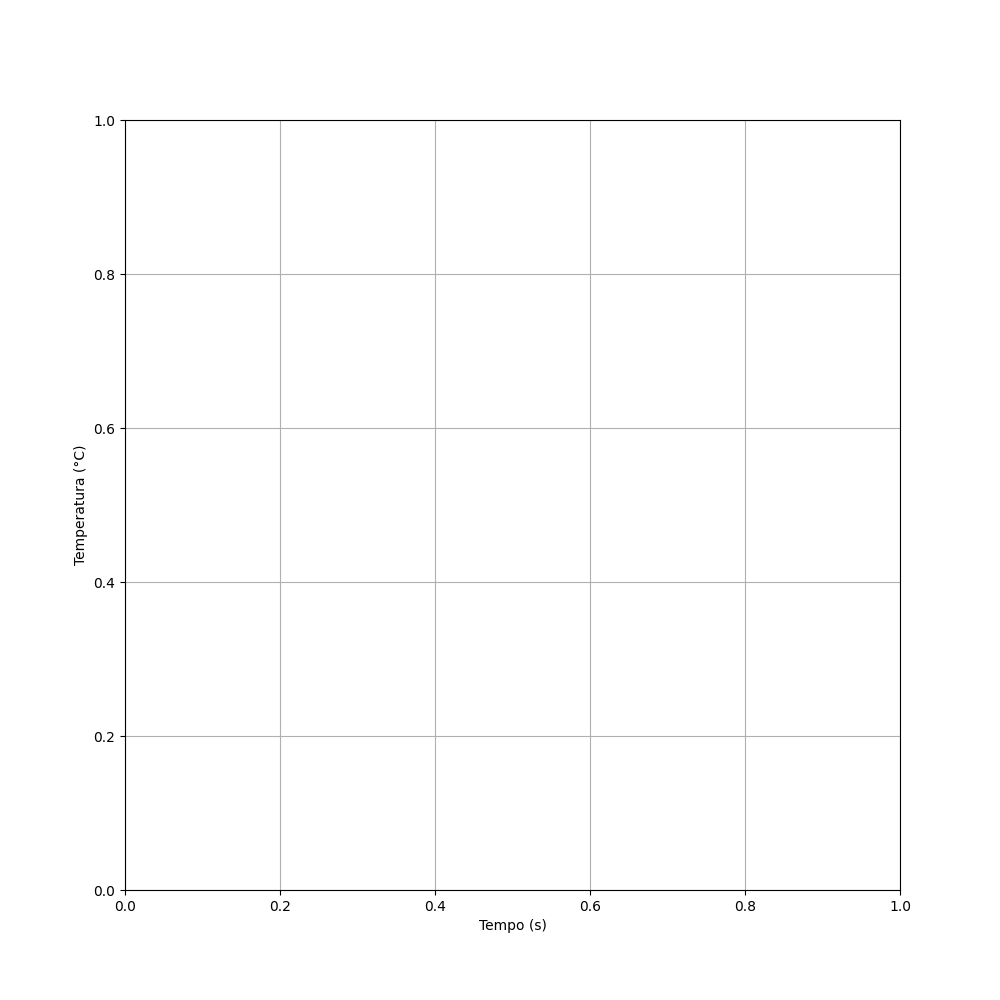

In [3]:
def new_figure():
    fig=plt.figure(figsize=[10,10])
    plt.grid()
    plt.xlabel('Tempo (s)')
    plt.ylabel('Temperatura (°C)')
    #plt.rcParams['figure.dpi'] = 150
    return fig

fig=new_figure()   

In [130]:
times = []
temps= []
getData(10,1)

[1.206, 1.837, 3.675, 5.512, 6.746, 7.98, 9.817, 11.655]


## Analisi dei dati

In questo esperimento useremo la relazione calorimetrica:

\begin{equation*}
	Q=mc\Delta T
\end{equation*}

dove il significato dei simboli dovrebbe essere noto. Per la determinazione del calore specifico di una sostanza, immersa all'interno dell'acqua presente nel calorimetro, nell'ipotesi di scambi termici nulli con l'esterno, potremmo scrivere:

\begin{equation}\label{cal1}
	m_sc_x(T_s-T_e)=m_ac_a(T_e-Ta)
\end{equation}
dove $c_x$ rappresenta il calore specifico da determinare, $m_s$ la massa del solido inserito nel calorimetro, $T_s$ la temperatura iniziale del solido, $m_a$ la massa d'acqua nel calorimetro, $T_a$ la temperatura iniziale dell'acqua, $c_a$ il calore specifico dell'acqua e $T_e$ la temperatura di equilibrio del sistema.
Ci possiamo accorgere immediatamente che pensare che la sola acqua contenuta all'interno del calorimetro, vada ad interagire con il solido, sia piuttosto ingenuo. In realtà tutto il calorimetro con i materiali in esso contenuti (agitatore, termometro$\ldots$) prende parte al processo di scambio termico. Dovremmo quindi sostituire, nel membro di destra della relazione per il calcolo della temperatura di equilibrio a $m_a$ il valore $m_a+m^*$ dove $m^*$ rappresenta l'equivalente in acqua del calorimetro in uso.

Per realizzare una misura corretta del calore specifico di una sostanza sarà quindi necessario, effettuare una calibrazione del calorimetro, misurando $m^*$.
Scaldiamo una massa $m'_a$ di acqua alla temperatura $T'_a$, ed inseriamola all'intero del nostro calorimetro in cui si trova una massa $m_a$ di acqua, in equilibrio termico con il calorimetro, alla temperatura $T_a$. Possiamo scrivere l'equazione

\begin{equation}
	m'_ac_a(T'_a-T_e)=(m_a+m^*)c_a(T_e-T_a)
\end{equation}

da cui ricaviamo l'equivalente in acqua del calorimetro:

\begin{equation}
	m^*=m'_a\dfrac{T'_a-T_e}{T_e-T_a}-m_a
\end{equation}

Di seguito viene riportata la procedura dettagliata per la misura dell'equivalente in acqua.

Hai a disposizione dei contenitori graduati di vario tipo:

- cilindri graduati da $50\ ml$ e $100\ ml$
- becher di diverse capacità con pinza o guanti per sollevarli dal fornello


Una volta verificato il volume di acqua che può contenere il vaso calorimetrico,  riempilo  con una quantità di acqua non inferiore a $300\ ml$. Questa quantità d'acqua è sufficiente per l’immersione del termometro e l’inserimento di almeno $200\ ml$ di acqua calda. Prepara un Becher con circa $300\ ml$ di acqua e collocalo sul fornello termostato, aspetta che raggiunga una temperatura nell'intervallo 50-60 °C. Ricorda di segnare i valori delle masse d'acqua $m_a$ ed $m'_a$. Inizia a misurare la temperatura dell'acqua all'interno del calorimetro, prima di inserire l'acqua calda, fallo ogni 5 secondi, usando la funzione ***getData***. Versa circa $200\ ml$ di acqua calda all'interno del calorimetro, ricorda anche di misurare (misura la massa iniziale prima di scaldare il Becher) la massa del Becher con l'acqua calda, prima e dopo aver versato parte del suo contenuto nel calorimetro. Questo ti permetterà di determinare per sottrazione la massa $m'_a$ d'acqua che andrai a versare nel vaso calorimetrico. Tappa il calorimetro e misura la temperatura ad intervalli di 5 secondi 




### Calcoli ed esempi

Importiamo le librerie per il calcolo della retta di regressione

In [15]:
from sklearn.linear_model import LinearRegression
import numpy as np

Esempio con dei dati di test ed calcolo diretto dei parametri delle rette di regressione

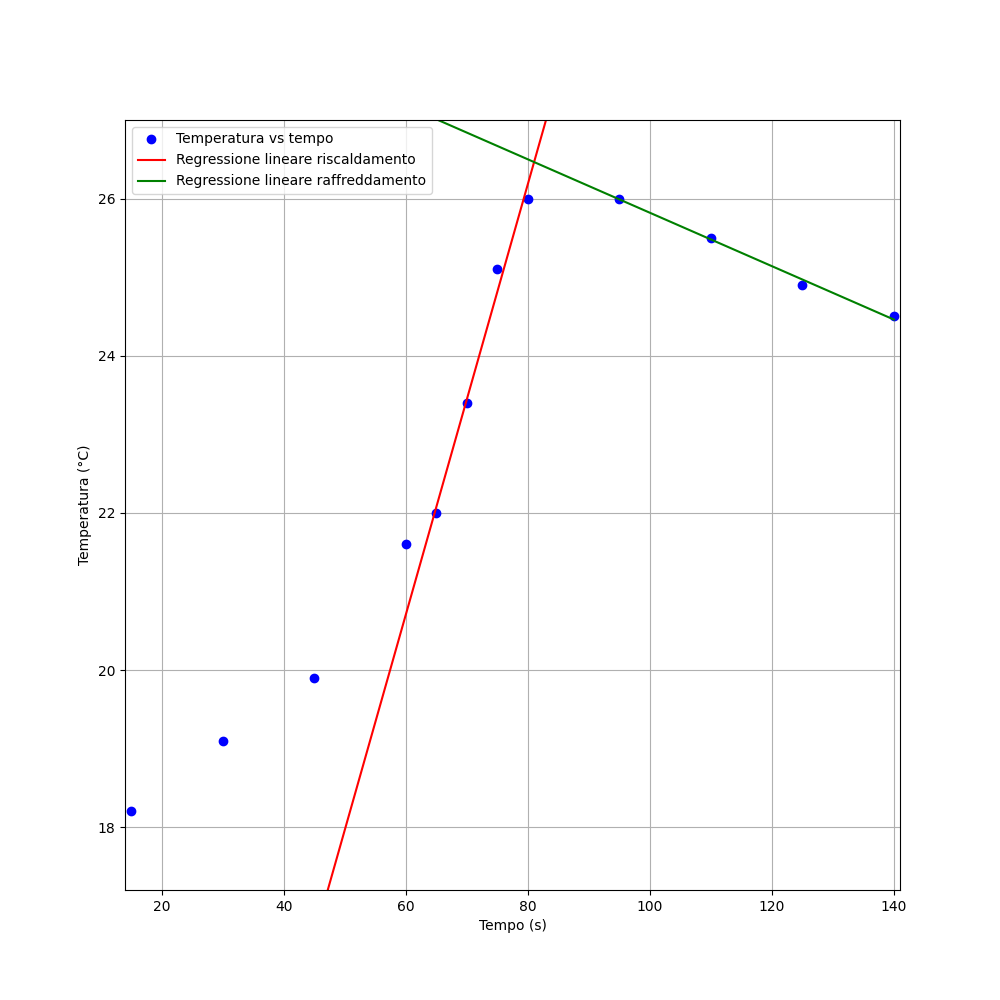

In [31]:
test_times=[15,30,45,60,65,70,75,80,95,110,125,140]
test_temps=[18.2,19.1,19.9,21.6,22,23.4,25.1,26,26,25.5,24.9,24.5]



figure_test,ax_test= plt.subplots(figsize=[10,10])
scatter_test, = ax_test.plot([], [], 'bo', label='Temperatura vs tempo')

plt.grid()
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')


line1_test, = ax_test.plot([], [], 'r', label='Regressione lineare riscaldamento')
line2_test, = ax_test.plot([], [], 'g', label='Regressione lineare raffreddamento')
ax_test.set_xlim(min(test_times)-1, max(test_times)+1)
ax_test.set_ylim(min(test_temps)-1,max(test_temps)+1)
ax_test.legend()

reg1 = LinearRegression()
reg2 = LinearRegression()
x_train1 = np.array(test_times[4:8]).reshape(-1, 1)
y_train1 = np.array(test_temps[4:8]).reshape(-1, 1)
reg1.fit(x_train1,y_train1)


x_train2 = np.array(test_times[8:13]).reshape(-1, 1)
y_train2 = np.array(test_temps[8:13]).reshape(-1, 1)
reg2.fit(x_train2,y_train2)



scatter_test.set_data(test_times,test_temps)
line1_test.set_data(test_times, reg1.predict(np.array([entry for entry in test_times]).reshape(-1, 1)))
line2_test.set_data(test_times, reg2.predict(np.array([entry for entry in test_times]).reshape(-1, 1)))





### Costruiamo una funzione

In questi casi, per semplificare il lavoro da svolgere, è sempre utile definire una funzione che produca il lavoro e fornisca in output i dati richiesti. La funzione ***get_reg_coeff** richiede in input i tempi raccolti, le temperature e gli intervalli di dati per cui calcolare le rette di regressione

[[0.27399999999999997, 4.260000000000002],
 [-0.033999999999999996, 29.220000000000002]]

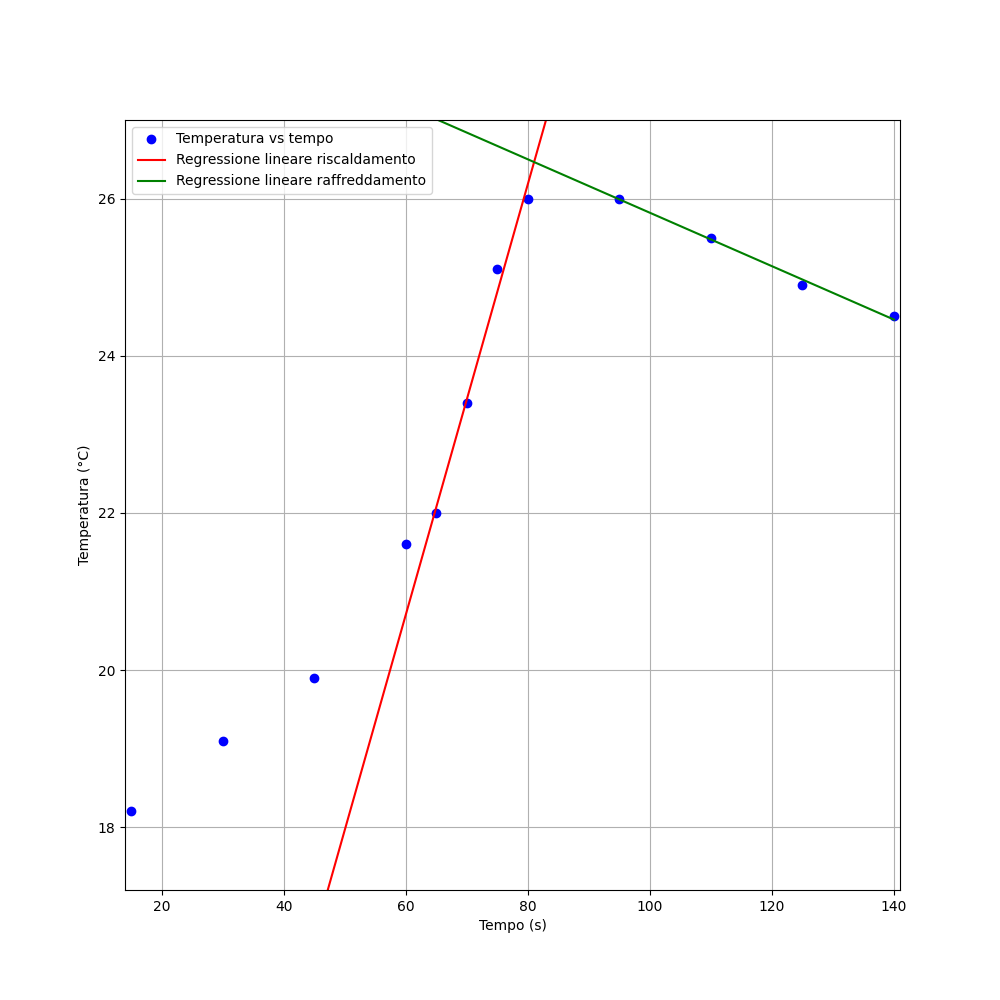

In [32]:
def get_reg_coeff(time_data,temp_data,interval1,interval2):

    #create  slice objects
    regd1=slice(interval1[0],interval1[1])
    regd2=slice(interval2[0],interval2[1])

    #create matplotlib figure
    regfigure,regax= plt.subplots(figsize=[10,10])
    regscatter, = regax.plot([], [], 'bo', label='Temperatura vs tempo')
    plt.grid()
    plt.xlabel('Tempo (s)')
    plt.ylabel('Temperatura (°C)')

    #setup reg lines and plot intervals
    regline1, = regax.plot([], [], 'r', label='Regressione lineare riscaldamento')
    regline2, = regax.plot([], [], 'g', label='Regressione lineare raffreddamento')
    regax.set_xlim(min(time_data)-1, max(time_data)+1)
    regax.set_ylim(min(temp_data)-1,max(temp_data)+1)
    regax.legend()


    #do the linear reg
    reg1 = LinearRegression()
    reg2 = LinearRegression()
    x_train1 = np.array(time_data[regd1]).reshape(-1, 1)
    y_train1 = np.array(temp_data[regd1]).reshape(-1, 1)
    reg1.fit(x_train1,y_train1)
    x_train2 = np.array(time_data[regd2]).reshape(-1, 1)
    y_train2 = np.array(temp_data[regd2]).reshape(-1, 1)
    reg2.fit(x_train2,y_train2)

    #collect results
    lines_data=[[reg1.coef_[0][0],reg1.intercept_[0]],[reg2.coef_[0][0],reg2.intercept_[0]]]

    #plot data
    regscatter.set_data(time_data,temp_data)
    regline1.set_data(time_data, reg1.predict(np.array([entry for entry in time_data]).reshape(-1, 1)))
    regline2.set_data(time_data, reg2.predict(np.array([entry for entry in time_data]).reshape(-1, 1)))
    return lines_data

get_reg_coeff(test_times,test_temps,[4,8],[8,13])







Per determinare la temperatura di equilibrio ora puoi scegliere se calcolare manuamente le coordinate del punto di incontro delle due rette di regressione nel piano (t,T), oppure scrivere una funzione che prende in input i parametri delle due rette e calcola le coordinate della loro intersezione. Se vuoi procedere con questo approccio, chiama la funzione **get_Te()**